In [ ]:
import io
import time
import torch
import torchaudio
import random

from encodec.model import EncodecModel

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import fastprogress
import numpy as np
import pylab as plt
import pandas as pd

In [ ]:
from IPython.display import Audio, HTML, display

In [ ]:
datadir = Path('/mnt/')

# Dataset

## Create a dataset index

In [ ]:
fnames = []
speakers = []
grps = []
for grp in ['small', 'medium', 'large']:
    for name in (Path('/scrach/')/grp).rglob('*.flac'):
        fnames.append(str(name))
        speakers.append(name.parents[1].name)
        grps.append(grp)

In [ ]:
data = pd.DataFrame(dict(afile=fnames, speaker=speakers, grp=grps))

In [ ]:
atoks = {x.name:x for x in list(Path(datadir).rglob('*.encodec'))}
stoks = {x.name:x for x in list(Path(datadir).rglob('*.stoks'))}

In [ ]:
data['atoks'] = data.apply(lambda x: str(atoks[Path(x['afile']).with_suffix('.encodec').name]), axis=1)
data['stoks'] = data.apply(lambda x: str(stoks[Path(x['afile']).with_suffix('.stoks').name]), axis=1)

In [ ]:
data.iloc[0]['atoks']

'/mnt/acoustic-small/254/accomplished_facts_sandburg_add_64kb.encodec'

In [ ]:
spks = data.groupby('speaker').count()

In [ ]:
spks.sort_values('afile')

,afile,grp,atoks,stoks
speaker,,,,
994,1,1,1,1
2306,1,1,1,1
4115,1,1,1,1
2311,1,1,1,1
4113,1,1,1,1
...,...,...,...,...
681,374,374,374,374
204,1439,1439,1439,1439
1401,2665,2665,2665,2665


In [ ]:
data.to_feather('token-dataset.feather')

## Load the dataset index

In [ ]:
data = pd.read_feather('token-dataset.feather')

In [ ]:
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, unique=False):
        self.data = data
        self.unique = unique
        self.samples = [(i,j) for i,name in enumerate(data['stoks']) for j in range(torch.load(name).shape[0])]
    
    def __len__(self):
        return len(self.samples)
    
    def S_tokens(self):
        return len(self)*1500
    
    def hours(self):
        return len(self)*30/3600
    
    def __repr__(self):
        return f"Dataset: {len(self)} samples, {self.S_tokens()} Stokens, {self.hours():.1f} hours)"
    
    def __getitem__(self, idx):
        i,j = self.samples[idx]
        row = self.data.iloc[i]
        jA = j * 2250
        Stoks = torch.load(row['stoks'], map_location='cpu')[j]
        Atoks = torch.load(row['atoks'], map_location='cpu')[0,:,jA:jA+2250].T.reshape(-1)
        if self.unique:
            x = torch.unique_consecutive(Stoks)
            Stoks = F.pad(x, (0, Stoks.shape[0] - x.shape[0]), value=1024)
        return Stoks, F.pad(Atoks, (0, 4500 - len(Atoks)), value=1024)

In [ ]:
data6454 = data[data['speaker'] == '6454']

In [ ]:
val_data, train_data = data6454[:5], data6454[5:100]
val_ds = SADataset(val_data, unique=False)
val_ds

Dataset: 322 samples, 483000 Stokens, 2.7 hours)

In [ ]:
train_ds = SADataset(train_data, unique=False)
train_ds

Dataset: 5748 samples, 8622000 Stokens, 47.9 hours)

# Modeling

In [ ]:
import IPython

class SimpleVisual:
    def __init__ (self, model, total_steps):
        self.model = model
        self.total_steps = total_steps
        
        gs = plt.GridSpec(2, 1, height_ratios=[3,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.lr_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
            
    def show(self):
        self.graph_out = display(self.graph_fig, display_id=True, clear=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, lr_p = self.loss_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        self.plot()

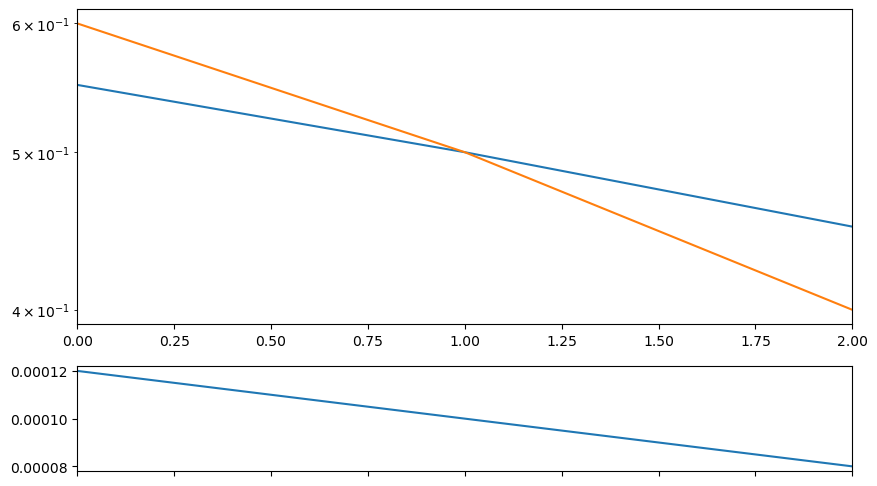

In [ ]:
visual = SimpleVisual({}, 2)
visual.show()
visual.add_data(0, 1.2e-4, 0.55, 0.6)
visual.add_data(1, 1e-4, 0.5, 0.5)
visual.add_data(2, 0.8e-4, 0.45, 0.4)
# visual.plot()
visual.hide()

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import random
import IPython

def train(model_name, model, train, val, half=False, bs=16, lr=1e-4, visual_class = SimpleVisual,
          weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10,
          run_valid_every_iters=100, table_row_every_iters=1000,
          device="cuda"):
    try:
        scheduler = None
        visual = visual_class(model, epochs*len(train))
        all_params = set(model.parameters())
        wd_params = set()
        for m in model.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                wd_params.add(m.weight)
                if m.bias is not None:
                    wd_params.add(m.bias)
        no_wd_params = all_params - wd_params

        optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
            params=[
                {"params": list(wd_params), "weight_decay": weight_decay},
                {"params": list(no_wd_params), "weight_decay": 0.0},
            ]
        )
        scaler = torch.cuda.amp.GradScaler(enabled=half)

        Path(f'/scrach/{model_name}-checkpoints').mkdir(exist_ok=True)
        
        train_loader = DataLoader(train, batch_size=bs, num_workers=8, drop_last=False, shuffle=True)
        val_loader = DataLoader(val, batch_size=bs, num_workers=8, drop_last=False)
        chkpt_every_iters = 5000

        it = 0
        start_t = time.time()
        next_val_it = it + 50
        next_chkpt_it = chkpt_every_iters
        next_table_it = table_row_every_iters
        
        val_loss = torch.nan
        avg_train_loss = torch.nan
        
        visual.show()

        mb = master_bar(range(epochs))
        mb.write(["samples", "train", "val", "time"], table=True)
        running_loss = [0]
        for epoch in mb:
            bar = progress_bar(train_loader, parent=mb)
            for xs,ys in bar:
                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                    ps, loss = model(xs.to(device), ys.to(device))

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if it > warmup:
                    if scheduler is None:
                        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(train_loader), epochs=epochs)
                    else:
                        scheduler.step()
                        lr = scheduler.get_last_lr()                    

                running_loss.append(loss.item())
                running_loss = running_loss[-5:]
                avg_train_loss = sum(running_loss)/len(running_loss)

                if it >= next_chkpt_it:
                    next_chkpt_it += chkpt_every_iters
                    torch.save(model.state_dict(), f'/scrach/{model_name}-checkpoints/{it}.pt')
                    
                if it >= next_val_it:
                    next_val_it += run_valid_every_iters
                    model.eval()
                    with torch.no_grad():
                        val_loss = 0
                        for xs,ys in val_loader:
                            with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                                ps, loss = model(xs.to(device), ys.to(device))
                            val_loss += loss
                        N = len(val_loader)
                        val_loss = val_loss.item() / N
                    model.train()
                    visual.add_data(it, lr, avg_train_loss, val_loss)
                
                if it >= next_table_it:
                    elapsed_t = time.time() - start_t
                    next_table_it += table_row_every_iters
                    mb.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)

                it += bs
                bar.comment = f"#{epoch+1}/{epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"
    except KeyboardInterrupt:
        mb.write(f"interrupted")
        mb.show()
        pass
    finally:
        visual.hide()

## Separate embeddings

In [ ]:
from torch import Tensor, nn
from typing import Dict, Iterable, Optional

import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)
    
class Linear(nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        return F.linear(
            x,
            self.weight.to(x.dtype),
            None if self.bias is None else self.bias.to(x.dtype),
        )

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

def init_transformer(m):
    if isinstance(m, (nn.Linear, nn.Embedding)):
        torch.nn.init.trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        torch.nn.init.constant_(m.bias, 0)
        torch.nn.init.constant_(m.weight, 1.0)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_state: int, n_head: int):
        super().__init__()
        self.n_head = n_head
        self.query = Linear(n_state, n_state)
        self.key = Linear(n_state, n_state, bias=False)
        self.value = Linear(n_state, n_state)
        self.out = Linear(n_state, n_state)

    def forward(
        self,
        x: Tensor,
        xa: Optional[Tensor] = None,
        mask: Optional[Tensor] = None,
        kv_cache: Optional[dict] = None,
    ):
        q = self.query(x)

        if kv_cache is None or xa is None or self.key not in kv_cache:
            # hooks, if installed (i.e. kv_cache is not None), will prepend the cached kv tensors;
            # otherwise, perform key/value projections for self- or cross-attention as usual.
            k = self.key(x if xa is None else xa)
            v = self.value(x if xa is None else xa)
        else:
            # for cross-attention, calculate keys and values once and reuse in subsequent calls.
            k = kv_cache[self.key]
            v = kv_cache[self.value]

        wv, qk = self.qkv_attention(q, k, v, mask)
        
        # save the attention matrix from the last batch
        self.last_qk = qk.cpu()
        
        return self.out(wv), qk

    def qkv_attention(
        self, q: Tensor, k: Tensor, v: Tensor, mask: Optional[Tensor] = None
    ):
        n_batch, n_ctx, n_state = q.shape
        scale = (n_state // self.n_head) ** -0.25
        q = q.view(*q.shape[:2], self.n_head, -1).permute(0, 2, 1, 3) * scale
        k = k.view(*k.shape[:2], self.n_head, -1).permute(0, 2, 3, 1) * scale
        v = v.view(*v.shape[:2], self.n_head, -1).permute(0, 2, 1, 3)

        qk = q @ k
        if mask is not None:
            qk = qk + mask[:n_ctx, :n_ctx]
        qk = qk.float()

        w = F.softmax(qk, dim=-1).to(q.dtype)

        # calculate and save the mean attention entropy
#         self.last_entropy = -(w * (w+1e-10).log()).sum(dim=-1).mean(dim=[0,-1])

        return (w @ v).permute(0, 2, 1, 3).flatten(start_dim=2), qk.detach()

class ResidualAttentionBlock(nn.Module):
    def __init__(self, n_state: int, n_head: int, cross_attention: bool = False):
        super().__init__()

        self.attn = MultiHeadAttention(n_state, n_head)
        self.attn_ln = LayerNorm(n_state)

        self.cross_attn = (
            MultiHeadAttention(n_state, n_head) if cross_attention else None
        )
        self.cross_attn_ln = LayerNorm(n_state) if cross_attention else None

        n_mlp = n_state * 4
        self.mlp = nn.Sequential(
            Linear(n_state, n_mlp), nn.GELU(), Linear(n_mlp, n_state)
        )
        self.mlp_ln = LayerNorm(n_state)
        
    def forward(
        self,
        x: Tensor,
        xa: Optional[Tensor] = None,
        mask: Optional[Tensor] = None,
        kv_cache: Optional[dict] = None,
    ):
        x = x + self.attn(self.attn_ln(x), mask=mask, kv_cache=kv_cache)[0]
        if self.cross_attn:
            x = x + self.cross_attn(self.cross_attn_ln(x), xa, kv_cache=kv_cache)[0]
        x = x + self.mlp(self.mlp_ln(x))
        return x

In [ ]:
# encoder model, accepts 1500 semantic tokens
class SEncoder(nn.Module):
    def __init__(self, sin_embs, depth=6, length=1500, width=384, S_codes=1024, n_head=6, unique_Stoks=False):
        super(SEncoder, self).__init__()
    
        # embed semantic tokens
        if unique_Stoks:
            S_codes += 1 # for padding
        self.embedding = nn.Embedding(S_codes, width)
        self.register_buffer("positional_embedding", sin_embs)

        self.layers = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks):
        xin = self.embedding(Stoks)
        
        assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        xin = (xin + self.positional_embedding).to(xin.dtype)

        return self.ln_post(self.layers(xin))

# AR decoder, accepts and outputs interleaved acoustic tokens (1024 is a start of sequence token)
class ADecoder(nn.Module):
    def __init__(self, sin_embs, depth=6, length=2250, width=384, A_codes=1024, n_head=6):
        super(ADecoder, self).__init__()
    
        # embed semantic tokens
        self.embedding = nn.Embedding(A_codes+1, width)
        self.register_buffer("positional_embedding", sin_embs)
        
        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head, cross_attention=True) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        mask = torch.empty(length*2, length*2).fill_(-np.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)

    def forward(self, Atoks, xenc):
        sot = self.embedding(torch.tensor([1024]).cuda()).repeat(Atoks.shape[0],1,1)
        if Atoks.shape[-1] > 0:
            if Atoks.shape[-1] > 1499:
                Atoks = Atoks[:,:-1]
            Aembs = self.embedding(Atoks)
            Aembs = torch.cat([sot, Aembs], dim=-2)
        else:
            Aembs = sot

        xin = (Aembs + self.positional_embedding[:Aembs.shape[1]]).to(xenc.dtype)
    
        x = xin
        for l in self.layers: x = l(x, xenc, mask=self.mask)
        
        x = self.ln_post(x)
        
        logits = (x @ self.embedding.weight.to(x.dtype).T).float()
        return logits

class SAARTransformer(nn.Module):
    def __init__(self, width=384, depth=6, n_head=6, unique_Stoks=False):
        super(SAARTransformer, self).__init__()

        pos_embs = sinusoids(4500, width)
        
        self.encoder = SEncoder(pos_embs[::3], width=width, n_head=n_head, depth=depth//2, unique_Stoks=unique_Stoks)
        self.decoder = ADecoder(pos_embs, width=width, n_head=n_head, depth=depth//2)
        
        self.apply(init_transformer)

    def forward(self, Stoks, Atoks, loss=True):
        xenc = self.encoder(Stoks.to(torch.long))
        logits = self.decoder(Atoks, xenc)
        if loss is not None:
            loss = F.cross_entropy(logits.reshape(-1,logits.shape[-1]), Atoks.view(-1))
        return logits, loss

In [ ]:
%pdb

Automatic pdb calling has been turned OFF


samples,train,val,time
20000,5.53106,5.94263,14:12
40000,4.65864,4.84021,28:19
60000,4.51140,4.36354,42:26
80000,4.15350,4.05065,56:33
100000,3.96748,3.77338,1:10:37
120000,3.66550,3.58858,1:24:39
140000,3.63487,3.43135,1:38:41
160000,3.52029,3.34730,1:53:01
180000,3.54077,3.27453,2:07:13
200000,3.45041,3.22819,2:21:17


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



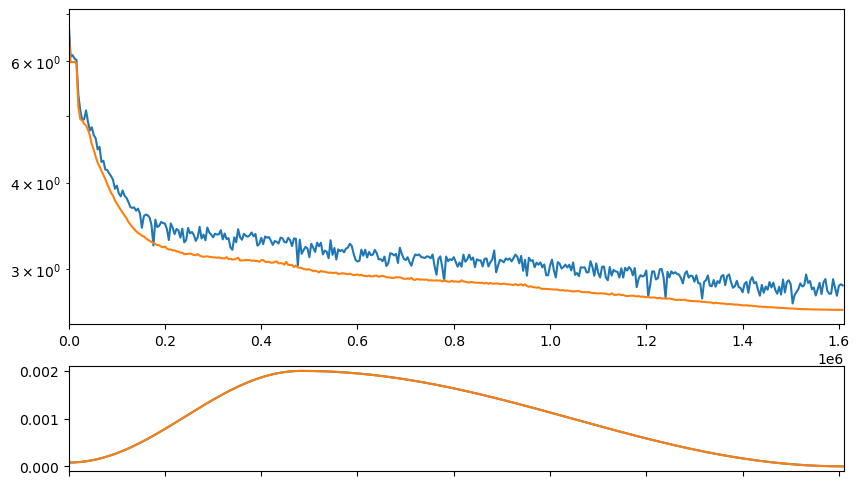

In [ ]:
model = SAARTransformer(depth=6).cuda()
train("saar-fixpos", model, train_ds, val_ds, half=True, bs=8, lr=2e-3, epochs=10, warmup=0,
      table_row_every_iters=20000, run_valid_every_iters=4000)

In [ ]:
torch.save(model.state_dict(), 'saar-1000h-posfix-ce2.62.pth')

## Explore the (cross-)attention weights

In [ ]:
model = SAARTransformer(depth=6).cuda()
model.load_state_dict(torch.load('saar-1000h-posfix-ce2.62.pth'))
model.eval().cuda();

In [ ]:
dl = DataLoader(train_ds, batch_size=16)

In [ ]:
bx, by = [x.cuda() for x in next(iter(dl))]

In [ ]:
with torch.no_grad(): model(bx, by)

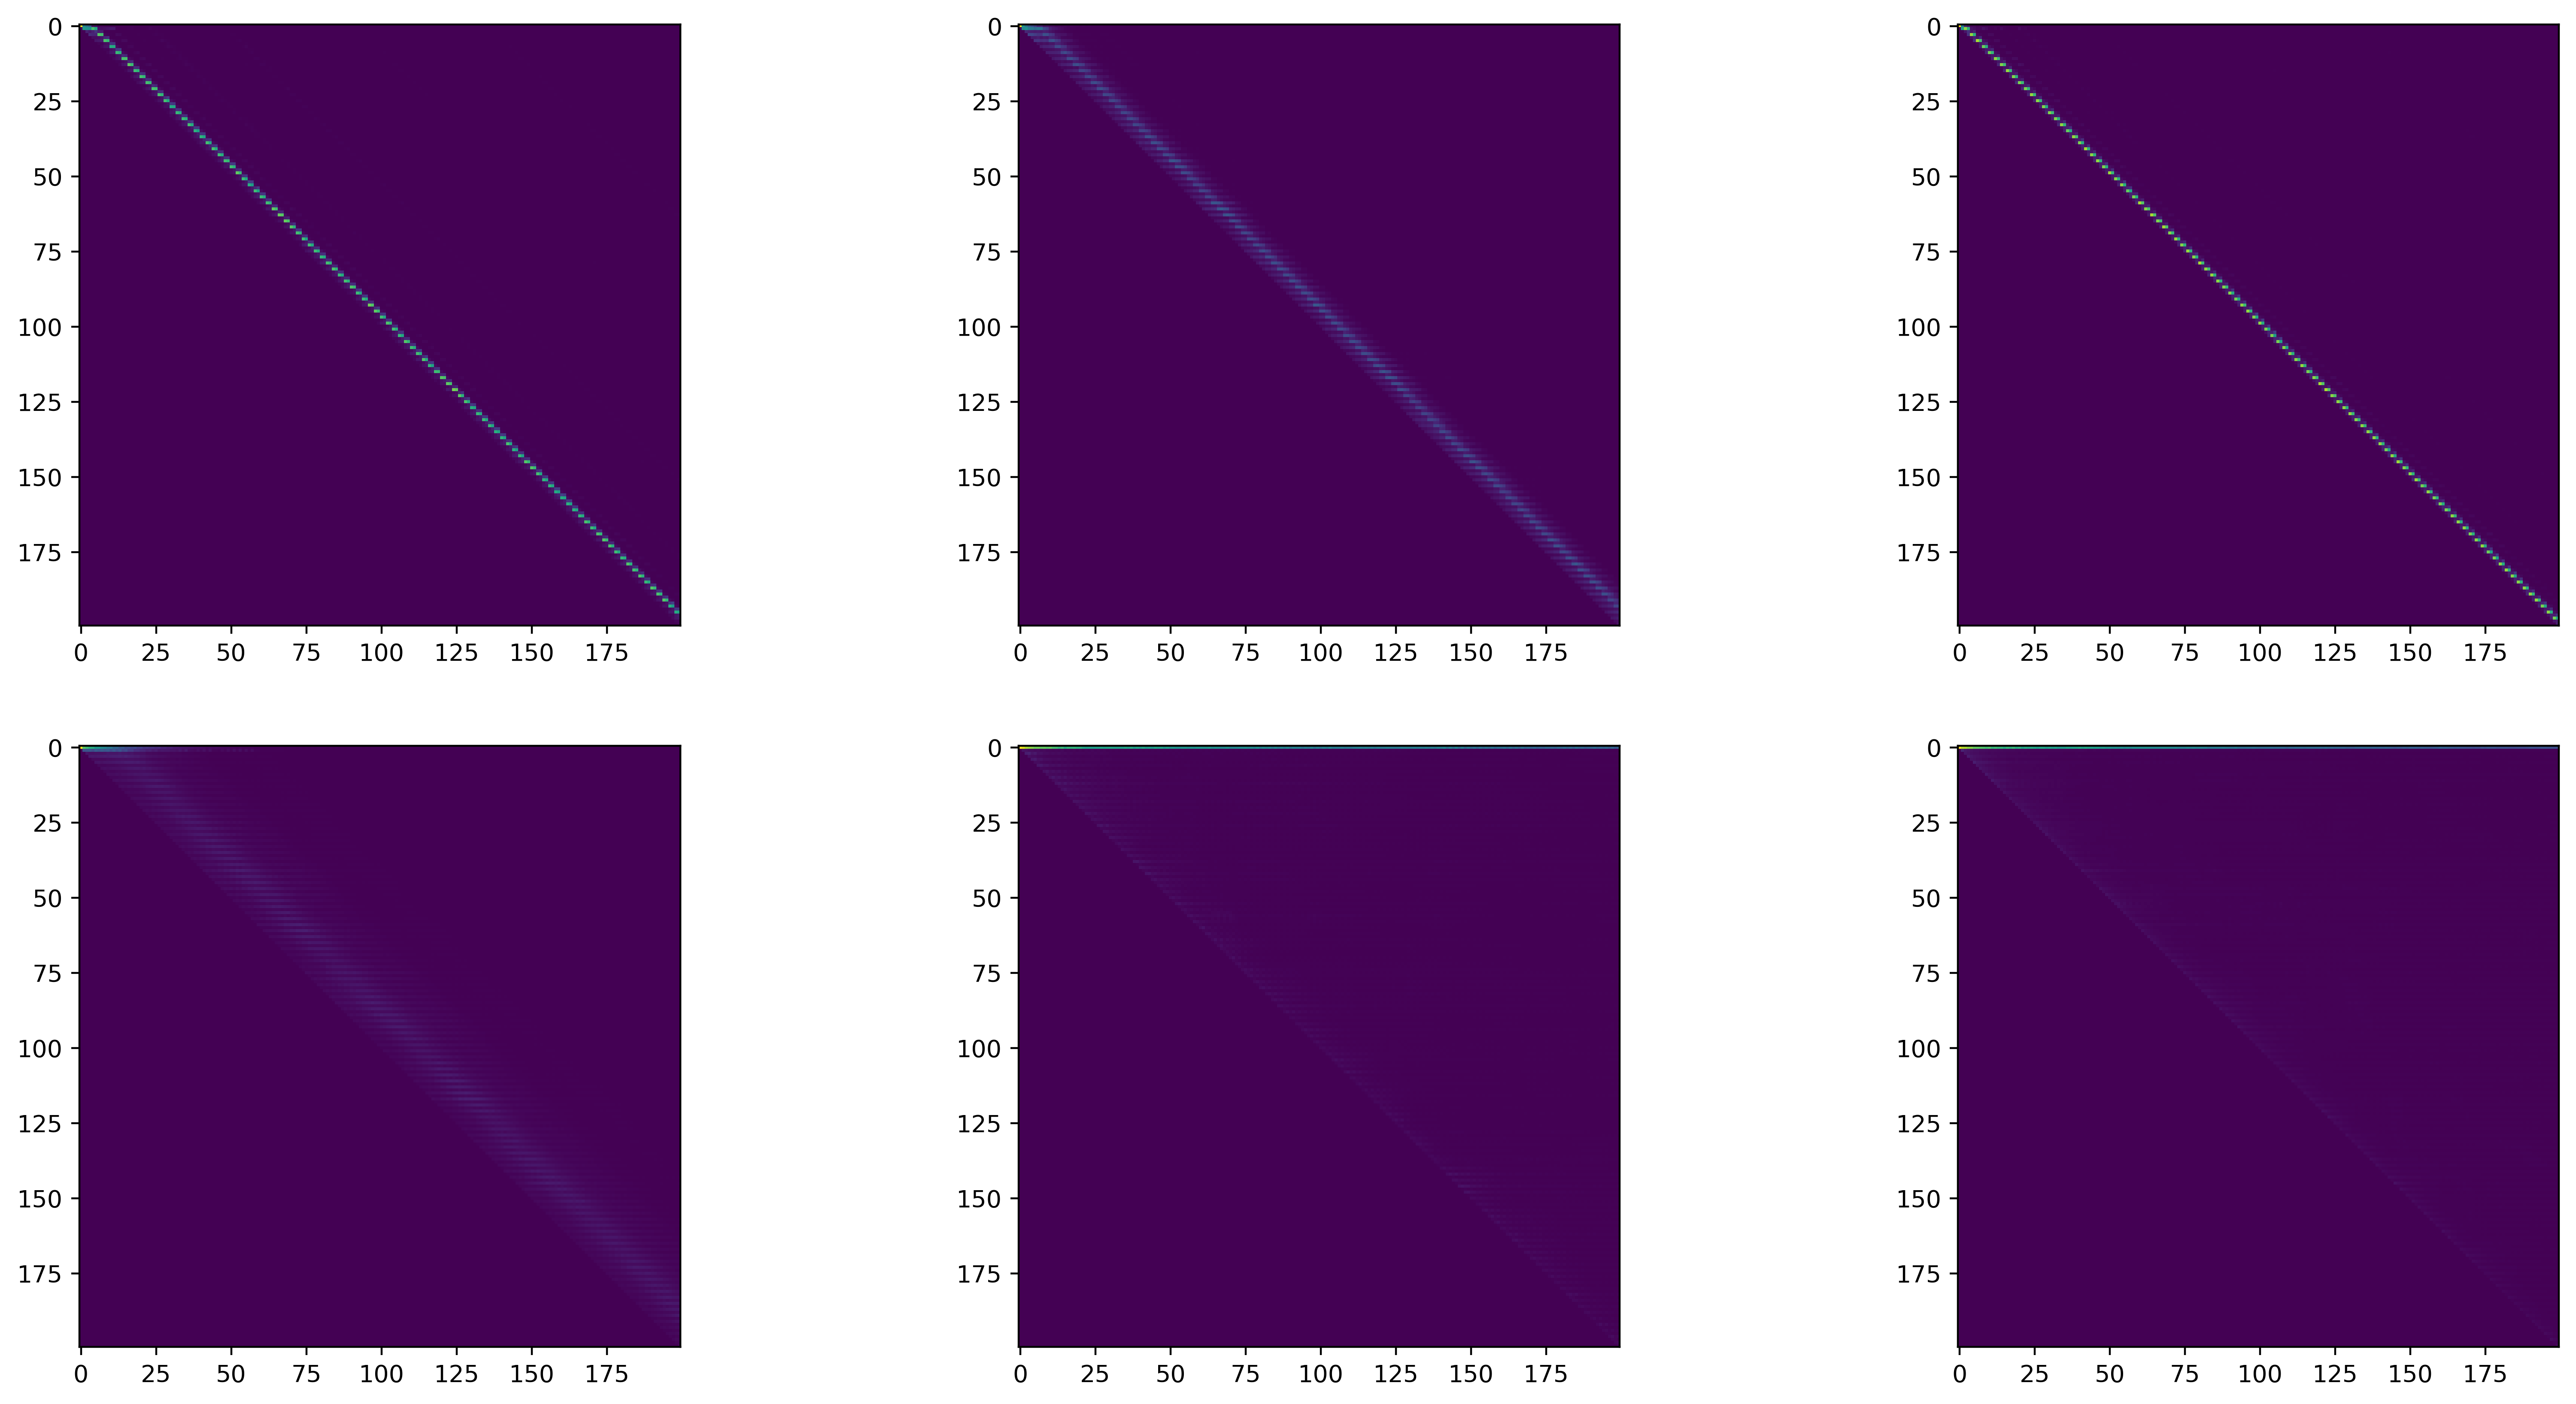

In [ ]:
# self-attention (for the first 200 tokens)
_, axs = plt.subplots(2,3,figsize=(20,10),dpi=400)
for ax,qk in zip(axs.reshape(-1), model.decoder.layers[2].attn.last_qk.softmax(-1).sum(0)):
    ax.imshow(qk[:200,:200].T)

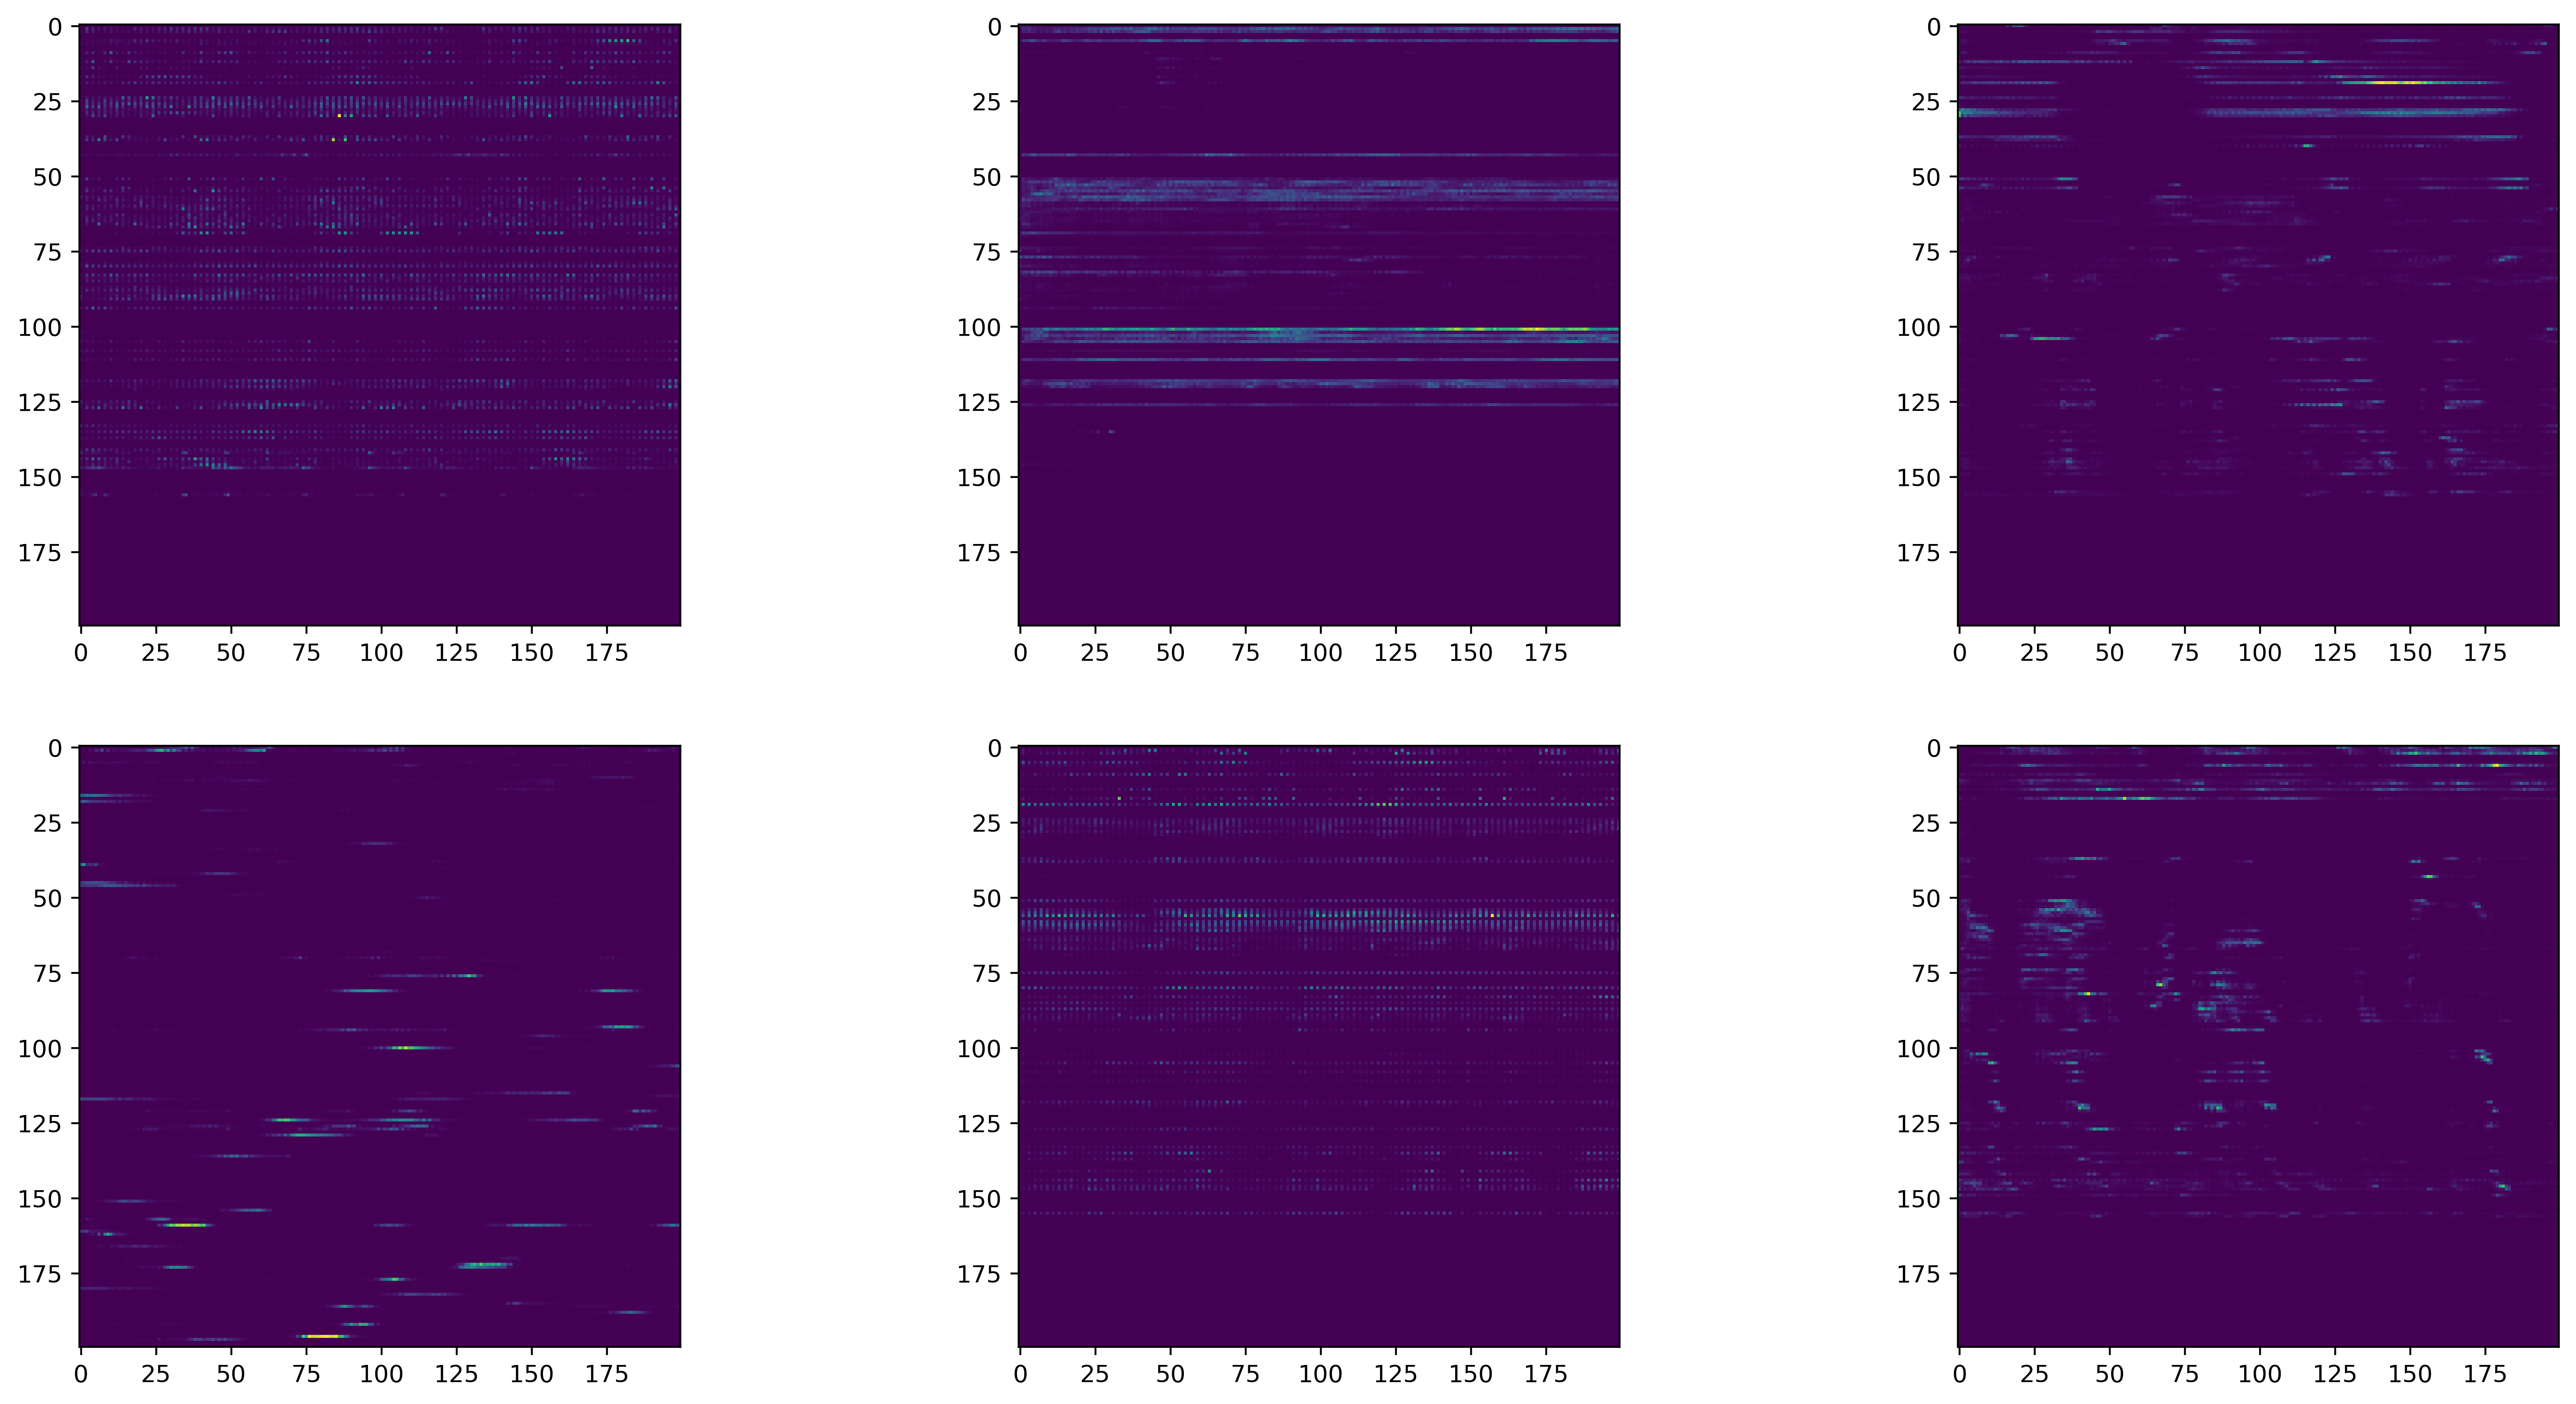

In [ ]:
# cross-attention (for the first 200 tokens, summed for the whole batch after softmax)
_, axs = plt.subplots(2,3,figsize=(20,10),dpi=400)
for ax,qk in zip(axs.reshape(-1), model.decoder.layers[2].cross_attn.last_qk.softmax(-1).sum(0)):
    ax.imshow(qk[:200,:200].T)

## Does the loss depend on the timestep

In [ ]:
dl = DataLoader(train_ds, batch_size=16)

In [ ]:
bx, by = [x.cuda() for x in next(iter(dl))]

In [ ]:
with torch.no_grad():
    logits, loss = model(bx, by)
loss

tensor(2.6925, device='cuda:0')

In [ ]:
loss = F.cross_entropy(logits.reshape(-1,logits.shape[-1]), by.cuda().view(-1), reduction='none').reshape(by.shape).cpu().numpy()

[<matplotlib.lines.Line2D>]

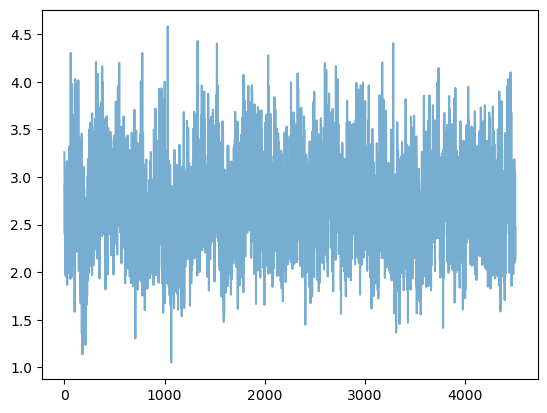

In [ ]:
plt.plot(loss.mean(0), alpha=.6)

# Sample from the model

In [ ]:
model = SAARTransformer(depth=6).cuda()
model.load_state_dict(torch.load('saar-1000h-posfix-ce2.62.pth'))
model.eval().cuda();

In [ ]:
from encodec.model import EncodecModel
Amodel = EncodecModel.encodec_model_24khz()
Amodel.set_target_bandwidth(1.5)
Amodel.cuda().eval();

In [ ]:
def save_wav(name, Atoks):
    with torch.no_grad():
        audio = Amodel.decode([(Atoks.reshape(-1,2).T.unsqueeze(0), torch.tensor(1).cuda())])[0]
    torchaudio.save(name, audio.cpu(), 24000)
    display(HTML(f'<a href="{name}" target="_blank">Listen to sample</a>'))

In [ ]:
dl = DataLoader(train_ds, batch_size=16)

In [ ]:
bx, by = [x.cuda() for x in next(iter(dl))]

In [ ]:
bx.shape, by.shape

(torch.Size([16, 1500]), torch.Size([16, 4500]))

In [ ]:
with torch.no_grad():
    logits, loss = model(bx, by)
loss

tensor(2.6925, device='cuda:0')

In [ ]:
# teacher forcing output (every output token sees the 100% correct context)
save_wav("test-teacher.wav", logits.argmax(-1)[0])

In [ ]:
# the ground truth compressed speech (the best we can hope for)
save_wav('ref.wav', by[0].cuda())

In [ ]:
# generate output using sampling, one token at a time
T=1
toks = []
for i in progress_bar(range(4500)):
    p, loss = model(bx[0:1], torch.tensor([toks]).cuda(), loss=None)
    last_p = p[0,-1]
    toks.append(torch.multinomial((last_p / T).softmax(-1), 1).item())
save_wav('test-gen.wav', torch.tensor(toks).cuda())